In [3]:
import pandas as pd
import numpy as np
import random

In [4]:
def preference_creation(family_size: int):
    if family_size == 1:
        preferences = [2,3]
    elif family_size == 2:
        preferences = [1,3,4]
    elif family_size == 3:
        preferences = [1,2,4]
    elif family_size == 4:
        preferences = [2,3,5]
    elif family_size == 5:
        preferences = [4,6]
    else:
        preferences = [5]
    
    output = [min(family_size, 6)] + random.sample(preferences, len(preferences))
    return output

def housing_vacancy(stock):
    
    # Probability weights for each housing type (reverse proportion to the key size)
    weights = [1 / key for key in stock]

    # Distribute 80 units randomly across types with weighted choice
    units_to_add = 80
    while units_to_add > 0:
        random_type = random.choices(list(stock.keys()), weights=weights)[0]
        add_count = random.randint(1, units_to_add)  # Random count to add

        # Increment the randomly chosen type by the add_count
        stock[random_type] += add_count

        units_to_add -= add_count  # Reduce the remaining units to add

    return stock


In [5]:
# import file
df = pd.read_csv("Eligible_Applicants.csv")

# filtering eligible applicants 
df = df[df['familysize'] != 0] # removing applicants with family size = 0
df = df[df['income'] != 0] # removing applicants with income = 0
df = df[df['race'] != 0]
df = df.drop(df.columns[0:1], axis = 1)
df = df[~(df['income'] > 14160 + (7710 * df['familysize']))]
df['waittime'] = 0
# df = df.loc[df.index.repeat(20)].reset_index(drop=True)


preferences = []
for index, row in df.iterrows():
    preferences.append(preference_creation(int(row['familysize'])))

df['preferences'] = preferences 

# saving original
safe = df
print(f"Total Number of Applicants: {len(df)}")

Total Number of Applicants: 3473


In [6]:
# housing unit stock
housing_units = {
    1: 9820,
    2: 4349,
    3: 3107,
    4: 1788,
    5: 880,
    6: 569
}
print(f"Total Housing Stock: {sum(housing_units.values())}")
# 1 in every 25 housing units available in the initial period
for key in housing_units.keys():
    housing_units[key] = housing_units[key] // 25 

print(f"Total Housing Units Available: {sum(housing_units.values())}")

Total Housing Stock: 20513
Total Housing Units Available: 817


In [40]:
df_output = pd.read_csv("results/Output Schema - outputs.csv")

df_output.iloc[0:8,:]
count = 2
experiment_no = 0


df_output.iloc[0:8, count]

0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
5   NaN
6   NaN
7   NaN
Name: w_income, dtype: float64

In [53]:
priorities = ['income', 'numchildren', 'numelderly', 'veteran', 'disability']
count = 2
experiments = 2
for experiment_no in range(experiments):
    for priority in priorities:
        # reset dataframe to infinite wait times and ranking = 0
        df = safe

        # sort dataframe by priority system and save to waitlist
        if priority == 'income':
            waitlist = df.sort_values(by=priority, ascending=True)
        else:
            waitlist = df.sort_values(by=priority, ascending=False)

        # maximum 5 years, allocating 12, end when waitlist is empty
        period = 12*5 
        for _ in range(int(period)):
            # break when waitlist is empty
            if waitlist.shape[0] == 0:
                break
            # add x number of housing units per cycle
            housing_units = housing_vacancy(housing_units)

            # for each applicant in the wait list
            for _, applicant in waitlist.iterrows():

                # identify the serial number
                serial_no = applicant['serialno']

                # for each choice in the preferences list
                for rank in applicant['preferences']:

                    # if that housing size/type is available
                    if housing_units[rank] > 0:

                        # set that housing choice to be their "ranking" (the preference they are matched with)
                        df.loc[df['serialno'] == serial_no, 'ranking'] = applicant['preferences'].index(rank) + 1

                        # reduce that available housing type by 1
                        housing_units[rank] -= 1

                        # remove them from the waitlist
                        waitlist = waitlist[waitlist['serialno'] != serial_no]
                        break
            
            # for all umatched, add 1 to waittime
            df.loc[df['ranking'] == 0, 'waittime'] += 1
        
        # Group by 'Race' and calculate the percentage of top choice within each group
        result = df.groupby('race').agg(
            Percentage=('ranking', lambda x: (x == 1).sum() / len(x) * 100),
            AverageWaitTime=('waittime', 'mean')
        ).reset_index()
        # Round 'Percentage' to 2 decimal points and format as percentage
        result['Percentage'] = result['Percentage'].map('{:.2f}%'.format)
        result.columns = ['Race', 'Percentage of Top Choice', 'Average Wait Time']

        top_choice = result['Percentage of Top Choice']
        avg_wait_time = result['Average Wait Time']

        n = len(top_choice)
        sum_tp = 0
        sum_wt = 0

        for i in range(8):
            for j in range(8):
                if i != j and float(top_choice[j][:-1]) != 0 and float(avg_wait_time[j]) != 0:
                    ratio_tp = float(top_choice[i][:-1])/float(top_choice[j][:-1])
                    ratio_wt = float(avg_wait_time[i])/float(avg_wait_time[j])
                    sum_tp += ratio_tp
                    sum_wt += ratio_wt
                    
        sum_tp = sum_tp / (n**2 - n)
        sum_wt = sum_wt / (n**2 - n)

        top_choice_fairness = abs(1 - sum_tp)
        wait_time_fairness = abs(1 - sum_wt)

        df_output.iloc[(experiment_no*8):(experiment_no*8)+8, count] = result['Average Wait Time']
        df_output.iloc[(experiment_no*8):(experiment_no*8)+8, count + 5] = result['Percentage of Top Choice']
        df_output.iloc[(experiment_no*8):(experiment_no*8)+8, count + 10] = [wait_time_fairness] * 8
        df_output.iloc[(experiment_no*8):(experiment_no*8)+8, count + 15] = [top_choice_fairness] * 8

        count += 1

print(df_output)  

IndexError: iloc cannot enlarge its target object

<Axes: title={'center': 'w_disability'}, xlabel='[race_id]'>

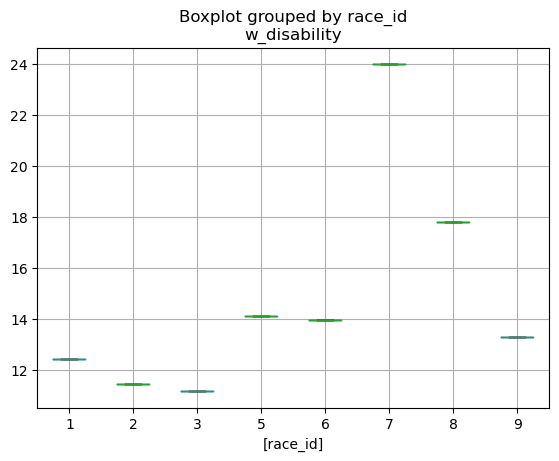

In [51]:
df_output.boxplot(column=['w_disability'], by =['race_id'])

In [10]:
# ONE TRIAL ONLY
priorities = ['income', 'numchildren', 'numelderly', 'veteran', 'disability']

for priority in priorities:
    # reset dataframe to infinite wait times and ranking = 0
    df = safe

    # sort dataframe by priority system and save to waitlist
    if priority == 'income':
        waitlist = df.sort_values(by=priority, ascending=True)
    else:
        waitlist = df.sort_values(by=priority, ascending=False)

    # maximum 5 years, allocating 12, end when waitlist is empty
    period = 12*5 
    for _ in range(int(period)):
        # break when waitlist is empty
        if waitlist.shape[0] == 0:
            break
        # add x number of housing units per cycle
        housing_units = housing_vacancy(housing_units)

        # for each applicant in the wait list
        for _, applicant in waitlist.iterrows():

            # identify the serial number
            serial_no = applicant['serialno']

            # for each choice in the preferences list
            for rank in applicant['preferences']:

                # if that housing size/type is available
                if housing_units[rank] > 0:

                    # set that housing choice to be their "ranking" (the preference they are matched with)
                    df.loc[df['serialno'] == serial_no, 'ranking'] = applicant['preferences'].index(rank) + 1

                    # reduce that available housing type by 1
                    housing_units[rank] -= 1

                    # remove them from the waitlist
                    waitlist = waitlist[waitlist['serialno'] != serial_no]
                    break
        
        # for all umatched, add 1 to waittime
        df.loc[df['ranking'] == 0, 'waittime'] += 1
    
    # save df
    filename = f'results/dfs/trial_3/housing_allocation_{priority}.csv'
    df.to_csv(filename, index = False)

    # Group by 'Race' and calculate the percentage of top choice within each group
    result = df.groupby('race').agg(
        Percentage=('ranking', lambda x: (x == 1).sum() / len(x) * 100),
        AverageWaitTime=('waittime', 'mean')
    ).reset_index()

    # Round 'Percentage' to 2 decimal points and format as percentage
    result['Percentage'] = result['Percentage'].map('{:.2f}%'.format)

    result.columns = ['Race', 'Percentage of Top Choice', 'Average Wait Time']

    top_choice = result['Percentage of Top Choice']
    avg_wait_time = result['Average Wait Time']

    n = len(top_choice)
    sum_tp = 0
    sum_wt = 0

    for i in range(8):
        for j in range(8):
            if i != j and float(top_choice[j][:-1]) != 0 and float(avg_wait_time[j]) != 0:
                ratio_tp = float(top_choice[i][:-1])/float(top_choice[j][:-1])
                ratio_wt = float(avg_wait_time[i])/float(avg_wait_time[j])
                sum_tp += ratio_tp
                sum_wt += ratio_wt
                
    sum_tp = sum_tp / (n**2 - n)
    sum_wt = sum_wt / (n**2 - n)

    top_choice_fairness = abs(1 - sum_tp)
    wait_time_fairness = abs(1 - sum_wt)

    print(f"Top Choice Fairness Metric For {priority}: {top_choice_fairness}")
    print(f"Waittime Fairness Metric For {priority}: {wait_time_fairness}")


In [26]:
priorities = ['income', 'numchildren', 'numelderly', 'veteran', 'disability']

for priority in priorities:
    result = pd.read_csv(f'results/stats/trial_3/housing_statistics_{priority}.csv')

    top_choice = result['Percentage of Top Choice']
    avg_wait_time = result['Average Wait Time']

    n = len(top_choice)
    sum_tp = 0
    sum_wt = 0

    for i in range(8):
        for j in range(8):
            if i != j and float(top_choice[j][:-1]) != 0 and float(avg_wait_time[j]) != 0:
                ratio_tp = float(top_choice[i][:-1])/float(top_choice[j][:-1])
                ratio_wt = float(avg_wait_time[i])/float(avg_wait_time[j])
                sum_tp += ratio_tp
                sum_wt += ratio_wt
                
    sum_tp = sum_tp / (n**2 - n)
    sum_wt = sum_wt / (n**2 - n)

    top_choice_fairness = abs(1 - sum_tp)
    wait_time_fairness = abs(1 - sum_wt)

    print(f"Top Choice Fairness Metric For {priority}: {top_choice_fairness}")
    print(f"Waittime Fairness Metric For {priority}: {wait_time_fairness}")


Top Choice Fairness Metric For income: 0.20963794645499423
Waittime Fairness Metric For income: 0.003566572518143629
Top Choice Fairness Metric For numchildren: 0.059565193711331954
Waittime Fairness Metric For numchildren: 0.06652244842519761
Top Choice Fairness Metric For numelderly: 0.02121001349887197
Waittime Fairness Metric For numelderly: 0.06652244842519761
Top Choice Fairness Metric For veteran: 0.03399363090358665
Waittime Fairness Metric For veteran: 0.06652244842519761
Top Choice Fairness Metric For disability: 0.08168197229555241
Waittime Fairness Metric For disability: 0.06652244842519761
